# C O N S E R V A T I V E - Q - L E A R N I N G - C Q L 

In [1]:
import torch
torch.set_float32_matmul_precision('highest')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np

import matplotlib.pyplot as plt
import tqdm

import copy

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split


### L O G G I N G

In [2]:
writer = SummaryWriter(log_dir = './runs/CQL')


### D E V I C E

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')


Device: cuda


### D A T A 

In [4]:
file = "C:\OFFLINE RL\hopper_medium-v2.hdf5"

with h5py.File(file, mode = 'r') as f:
    
    observations = np.array(f['observations'])
    actions = np.array(f['actions'])
    rewards = np.array(f['rewards'])
    next_obs = np.array(f['next_observations'])
    terminals = np.array(f['terminals'])
    timeout = np.array(f['timeouts'])
    
state_dim = observations.shape[1]
action_dim = actions.shape[1]
max_action = abs(actions).max()    
    
print(f'Len of data: {len(observations)}')
print(f'state dim: {state_dim} | action dim: {action_dim} | max action: {max_action}')


Len of data: 1000000
state dim: 11 | action dim: 3 | max action: 0.9999945163726807


### D A T A - F E A T U R I N G

In [5]:
obs_ten = torch.from_numpy(observations).float().to(device)
act_ten = torch.from_numpy(actions).float().to(device)
rew_ten = torch.from_numpy(rewards).float().to(device)
next_obs_ten = torch.from_numpy(next_obs).float().to(device)

don = terminals | timeout
don_ten = torch.from_numpy(don).float().to(device)



class Hopper_Dataset(Dataset):
    
    def __init__(self, obs = obs_ten, act = act_ten, rew = rew_ten, don = don_ten, next_obs = next_obs_ten):
        
        self.states = obs
        self.actions = act
        self.rewards = rew
        self.next_states = next_obs
        self.dones = don
        
    def __len__(self):
        
        return len(self.states)
    
    def __getitem__(self, index):
        
        return self.states[index], self.actions[index], self.rewards[index], self.next_states[index], self.dones[index]
    
dataset = Hopper_Dataset()

train_data, test_data = train_test_split(dataset, test_size = 0.1, shuffle = False)

train_loader, test_loader = DataLoader(train_data, batch_size = 256, shuffle = True, drop_last = True), DataLoader(test_data, batch_size = 256, shuffle = True, drop_last = True)


### A S S E M B L Y

In [6]:
head_1 = 128
head_2 = 256
head_3 = 256
head_4 = 128

hidden_size = 128
hidden_size_2 = 256


### F E A T U R E 

In [7]:
class Feature_Extractor(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size = hidden_size, hidden_size_2 = hidden_size_2):
        super(Feature_Extractor, self).__init__()
        
        self.extract = nn.Sequential(
            
            nn.Linear(input_dim, hidden_size),
            nn.SiLU(),
            
            nn.Linear(hidden_size, hidden_size_2),
            nn.SiLU(),
            
            nn.LayerNorm(hidden_size_2),
            nn.Linear(hidden_size_2, hidden_size),
            nn.SiLU(),
            
            nn.Linear(hidden_size, output_dim),
            nn.SiLU()
        )
        
    def forward(self, x):
        
        return self.extract(x)


### P O L I C Y

In [8]:
class policy_net(nn.Module):
    
    def __init__(self, state_dim = state_dim, action_dim = action_dim, max_action = max_action, head_1 = head_1, head_2 = head_2, head_3 = head_3, head_4 = head_4):
        super(policy_net, self).__init__()
        
        # feature
        
        self.feature = Feature_Extractor(state_dim, head_1)
        
        # norm 
        
        self.norm = nn.LayerNorm(head_1)
        
        # process
        
        self.process = nn.Sequential(
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            nn.Linear(head_3, head_4),
            nn.SiLU()
        )
        
        # mu head
        
        self.mu = nn.Linear(head_4, action_dim)
        
        # max action
        
        self.max_action = max_action
                
    def forward(self, state):
        
        # feature
        
        feature = self.feature(state)
        
        # norm
        
        norm = self.norm(feature)

        # process
        
        process = self.process(norm)
        
        # mu head
        
        mu = self.mu(process)
        
        tanh_mu = torch.tanh(mu)
               
        action = tanh_mu * self.max_action
        
        return action 
        

### Q NETWORK


In [9]:
class q_net(nn.Module):
    
    def __init__(self, state_dim = state_dim, action_dim = action_dim, head_1 = head_1, head_2 = head_2, head_3 = head_3, head_4 = head_4):
        super(q_net, self).__init__()
        
        # q vals 1 
        
        self.q_1 = nn.Sequential(
            
            nn.Linear(state_dim + action_dim, head_1),
            nn.SiLU(),
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            nn.Linear(head_3, head_4),
            nn.SiLU(),
            
            nn.Linear(head_4, 1)
        )
        
        # q vals 2
        
        self.q_2 = nn.Sequential(
            
            nn.Linear(state_dim + action_dim, head_1),
            nn.SiLU(),
            
            nn.Linear(head_1, head_2),
            nn.SiLU(),
            
            nn.LayerNorm(head_2),
            nn.Linear(head_2, head_3),
            nn.SiLU(),
            
            nn.Linear(head_3, head_4),
            nn.SiLU(),
            
            nn.Linear(head_4, 1)
        )
        
    def forward(self, state, action):
        
        # cat
        
        cat = torch.cat([state, action], dim = -1)
        
        q1 = self.q_1(cat)
        q2 = self.q_2(cat)
        
        return q1, q2


### S E T U P 

In [10]:
# Policy

POLICY_NETWORK = policy_net().to(device)

print(POLICY_NETWORK)
print('-' * 100)

# Q network

Q_NETWORK = q_net().to(device)

print(Q_NETWORK)

# target policy

TARGET_POLICY = copy.deepcopy(POLICY_NETWORK).to(device)

# target q

TARGET_Q_NET = copy.deepcopy(Q_NETWORK).to(device)


policy_net(
  (feature): Feature_Extractor(
    (extract): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): SiLU()
      (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (5): Linear(in_features=256, out_features=128, bias=True)
      (6): SiLU()
      (7): Linear(in_features=128, out_features=128, bias=True)
      (8): SiLU()
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (process): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
  )
  (mu): Linear(in_features=128, out_features=3, bias=True)
)
----------------------------------------------------------------------------------------------------
q_net(
  (q_1): Sequential(
    (0): L

### O P T I M I Z E R - S C H E D U L E R 

In [11]:
# lr

policy_lr = 1e-4
q_lr = 1e-4

T_max = 30

policy_optimizer = optim.AdamW(POLICY_NETWORK.parameters(), policy_lr, weight_decay = 0)
policy_scheduler = optim.lr_scheduler.CosineAnnealingLR(policy_optimizer, T_max, eta_min = 1e-6)

q_optimizer = optim.AdamW(Q_NETWORK.parameters(), q_lr, weight_decay = 0)
q_scheduler = optim.lr_scheduler.CosineAnnealingLR(q_optimizer, T_max, eta_min = 1e-6)


### L O S S - F U N C


In [12]:
class loss_func:
    
    def __init__(self, gamma, tau, alpha, policy_noise, noise_clip, delay, POLICY_NETWORK = POLICY_NETWORK, Q_NETWORK = Q_NETWORK, TARGET_POLICY = TARGET_POLICY, TARGET_Q_NET = TARGET_Q_NET, policy_optimizer = policy_optimizer, policy_scheduler = policy_scheduler, q_optimizer = q_optimizer, q_scheduler = q_scheduler, max_action = max_action):
        
        # network
        
        self.policy = POLICY_NETWORK
        self.q_network = Q_NETWORK
        self.target_policy = TARGET_POLICY
        self.target_q_network = TARGET_Q_NET
        
        # hyper param
        
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.max_action = max_action
        self.delay = delay
        
        # optimizer and scheduler
        
        self.policy_optimizer = policy_optimizer
        self.policy_scheduler = policy_scheduler
        self.q_optimizer = q_optimizer
        self.q_scheduler = q_scheduler
        
    def soft_update(self, source, target):
        
        with torch.no_grad():
            
            for param, target_param in zip(source.parameters(), target.parameters()):
                
                target_param.data.copy_(param.data * self.tau + target_param.data * (1 - self.tau))
                
    def critic_loss(self, states, actions, rewards, dones, next_states):
        
        # cal bootstrapped target
        
        with torch.no_grad():
            
            noise = (torch.randn_like(actions) * self.policy_noise).clip(-self.noise_clip, self.noise_clip)
            
            next_actions = (self.target_policy(next_states) + noise).clip(-self.max_action, self.max_action)
            
            target_1, target_2 = self.target_q_network(next_states, next_actions)
            target = torch.min(target_1, target_2)
            target_vals = rewards + self.gamma * (1 - dones) * target
            
        # cal current vals
        
        q1, q2 = self.q_network(states, actions)
        loss_1 = F.mse_loss(q1, target_vals) + F.mse_loss(q2, target_vals)
        
        
        # cal second loss
        
        policy_actions = self.policy(states)
        q1_pi, q2_pi = self.q_network(states, policy_actions)
        
        loss_2 = self.alpha * ((q1_pi.mean() + q2_pi.mean()) / 2 - (q1.mean() + q2.mean()) / 2)
        
        q_loss = loss_1 + loss_2
         
        return q_loss   
    
    def policy_loss(self, states):
        
        policy_actions = self.policy(states)
        
        q1, _ = self.q_network(states, policy_actions)
        
        policy_loss = - q1.mean()
            
        return policy_loss
        
    def update(self, data_loader):
        
        running_policy_loss = 0.0
        running_q_loss = 0.0
        step = 0
        
        for states, actions, rewards, next_states, dones in data_loader:
            
            if rewards.dim() ==1: rewards = rewards.unsqueeze(1)
            if dones.dim() == 1: dones = dones.unsqueeze(1)
            
            # critic loss
            
            q_loss = self.critic_loss(states, actions, rewards, dones, next_states)
            
            self.q_optimizer.zero_grad()
            q_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm = 0.5)
            self.q_optimizer.step()
            self.q_scheduler.step()
            
            running_q_loss += q_loss.item()
            
            # policy loss
            
            if step % self.delay == 0:
                
                policy_loss = self.policy_loss(states)
                
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm= 0.5)
                self.policy_optimizer.step()
                self.policy_scheduler.step()
                
                running_policy_loss += policy_loss.item()
            
            self.soft_update(self.q_network, self.target_q_network)
            self.soft_update(self.policy, self.target_policy)
            
            step += 1
            
        avg_policy_loss = running_policy_loss / max(1, (step // self.delay))
        avg_q_loss = running_q_loss / step
        
        return avg_policy_loss, avg_q_loss


### S E T U P 

In [13]:
# hyper params

gamma = 0.97
alpha = 1.0
tau = 0.005
noise_clip = 0.3
policy_noise = 0.2
delay = 2

LOSS_FUNCTION = loss_func(gamma, tau, alpha, policy_noise, noise_clip, delay)


### T R A I N I N G


In [ ]:
epochs = 30

total_policy_loss = []
total_q_loss = []
best_q_loss = -np.inf

for epoch in tqdm.tqdm(range(epochs), desc = 'CQL TRAINING'):
    
    avg_policy_loss, avg_q_loss = LOSS_FUNCTION.update(train_loader)
    
    writer.add_scalar('POLICY LOSS', avg_policy_loss, epoch)
    writer.add_scalar('Q LOSS', avg_q_loss, epoch)
    
    total_policy_loss.append(avg_policy_loss)
    total_q_loss.append(avg_q_loss)
    
    writer.flush()
    
    tqdm.tqdm.write(f'Epoch: {epoch} | policy loss: {avg_policy_loss:.4f} | Q loss: {avg_q_loss:.4f}')
    


CQL TRAINING:   3%|▎         | 1/30 [01:43<49:57, 103.37s/it]

Epoch: 0 | policy loss: -22.0875 | Q loss: 1.7166


CQL TRAINING:   7%|▋         | 2/30 [03:34<50:25, 108.06s/it]

Epoch: 1 | policy loss: -55.2672 | Q loss: 3.2478


CQL TRAINING:  10%|█         | 3/30 [05:27<49:35, 110.22s/it]

Epoch: 2 | policy loss: -76.3391 | Q loss: 3.6661


CQL TRAINING:  13%|█▎        | 4/30 [06:51<43:20, 100.00s/it]

Epoch: 3 | policy loss: -89.4041 | Q loss: 4.2573


CQL TRAINING:  17%|█▋        | 5/30 [08:11<38:40, 92.80s/it] 

Epoch: 4 | policy loss: -97.4667 | Q loss: 5.0218


CQL TRAINING:  20%|██        | 6/30 [09:29<35:02, 87.62s/it]

Epoch: 5 | policy loss: -102.1135 | Q loss: 5.0253


CQL TRAINING:  23%|██▎       | 7/30 [11:02<34:19, 89.52s/it]

Epoch: 6 | policy loss: -105.1376 | Q loss: 4.8628


CQL TRAINING:  27%|██▋       | 8/30 [12:24<31:56, 87.09s/it]

Epoch: 7 | policy loss: -105.8774 | Q loss: 4.0765


CQL TRAINING:  30%|███       | 9/30 [13:47<30:00, 85.74s/it]

Epoch: 8 | policy loss: -105.8180 | Q loss: 3.2997


CQL TRAINING:  33%|███▎      | 10/30 [15:12<28:29, 85.49s/it]

Epoch: 9 | policy loss: -105.7082 | Q loss: 3.1404


CQL TRAINING:  37%|███▋      | 11/30 [16:33<26:40, 84.26s/it]

Epoch: 10 | policy loss: -105.5615 | Q loss: 2.6573


CQL TRAINING:  40%|████      | 12/30 [18:03<25:46, 85.92s/it]

Epoch: 11 | policy loss: -104.7832 | Q loss: 2.2938


CQL TRAINING:  43%|████▎     | 13/30 [19:39<25:13, 89.02s/it]

Epoch: 12 | policy loss: -103.8980 | Q loss: 2.1073


CQL TRAINING:  47%|████▋     | 14/30 [21:01<23:06, 86.67s/it]

Epoch: 13 | policy loss: -103.1665 | Q loss: 1.9794


CQL TRAINING:  50%|█████     | 15/30 [22:51<23:28, 93.91s/it]

Epoch: 14 | policy loss: -102.6066 | Q loss: 1.8303


CQL TRAINING:  53%|█████▎    | 16/30 [24:37<22:44, 97.48s/it]

Epoch: 15 | policy loss: -102.1691 | Q loss: 1.6722


CQL TRAINING:  57%|█████▋    | 17/30 [26:00<20:09, 93.02s/it]

Epoch: 16 | policy loss: -101.6238 | Q loss: 1.5393


CQL TRAINING:  60%|██████    | 18/30 [27:28<18:19, 91.59s/it]

Epoch: 17 | policy loss: -101.1532 | Q loss: 1.4763


CQL TRAINING:  63%|██████▎   | 19/30 [29:24<18:08, 98.99s/it]

Epoch: 18 | policy loss: -100.6994 | Q loss: 1.4203


CQL TRAINING:  67%|██████▋   | 20/30 [30:55<16:05, 96.58s/it]

Epoch: 19 | policy loss: -100.4293 | Q loss: 1.4032


CQL TRAINING:  70%|███████   | 21/30 [32:32<14:28, 96.54s/it]

Epoch: 20 | policy loss: -100.3091 | Q loss: 1.3442


CQL TRAINING:  73%|███████▎  | 22/30 [34:03<12:40, 95.03s/it]

Epoch: 21 | policy loss: -100.2005 | Q loss: 1.3174


CQL TRAINING:  77%|███████▋  | 23/30 [35:33<10:54, 93.51s/it]

Epoch: 22 | policy loss: -100.0654 | Q loss: 1.2794


CQL TRAINING:  80%|████████  | 24/30 [37:04<09:15, 92.64s/it]

Epoch: 23 | policy loss: -99.8590 | Q loss: 1.2578


CQL TRAINING:  83%|████████▎ | 25/30 [38:43<07:53, 94.70s/it]

Epoch: 24 | policy loss: -99.7938 | Q loss: 1.1976


CQL TRAINING:  87%|████████▋ | 26/30 [40:14<06:14, 93.66s/it]

Epoch: 25 | policy loss: -99.7237 | Q loss: 1.1684


CQL TRAINING:  90%|█████████ | 27/30 [41:44<04:37, 92.57s/it]

Epoch: 26 | policy loss: -99.5895 | Q loss: 1.1505


CQL TRAINING:  93%|█████████▎| 28/30 [43:25<03:10, 95.04s/it]

Epoch: 27 | policy loss: -99.5325 | Q loss: 1.1242


CQL TRAINING:  97%|█████████▋| 29/30 [44:54<01:33, 93.09s/it]

Epoch: 28 | policy loss: -99.4746 | Q loss: 1.0991


CQL TRAINING: 100%|██████████| 30/30 [46:24<00:00, 92.83s/it]

Epoch: 29 | policy loss: -99.4771 | Q loss: 1.0770


### P L O T S

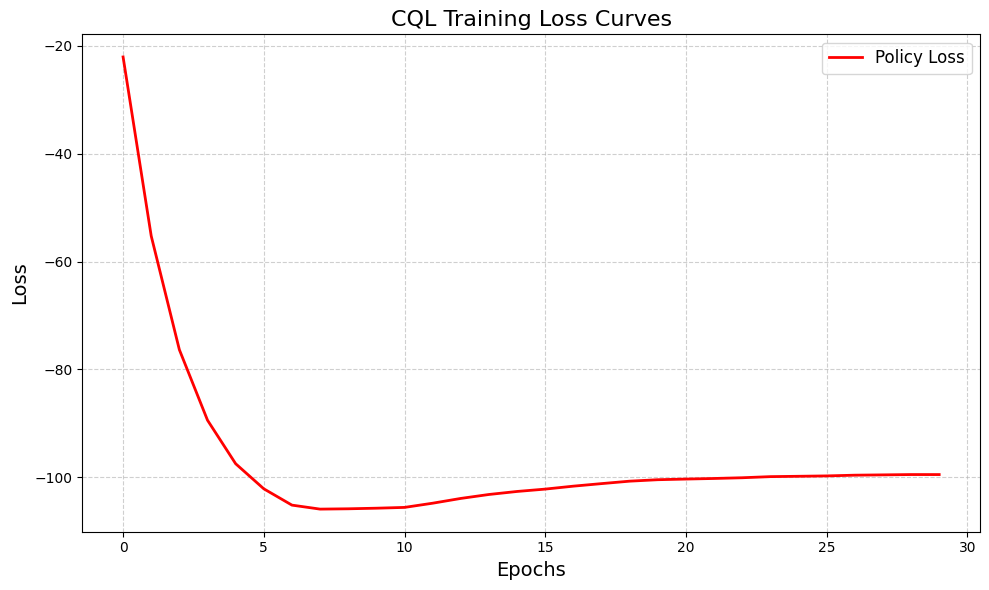

In [ ]:
plot_length = range(len(total_policy_loss))

plt.figure(figsize=(10, 6))

plt.plot(plot_length, total_policy_loss, label='Policy Loss', color='red', linewidth=2)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('CQL Training Loss Curves', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('CQL_loss_curves.png', dpi=300)  # Save as PNG
plt.show()


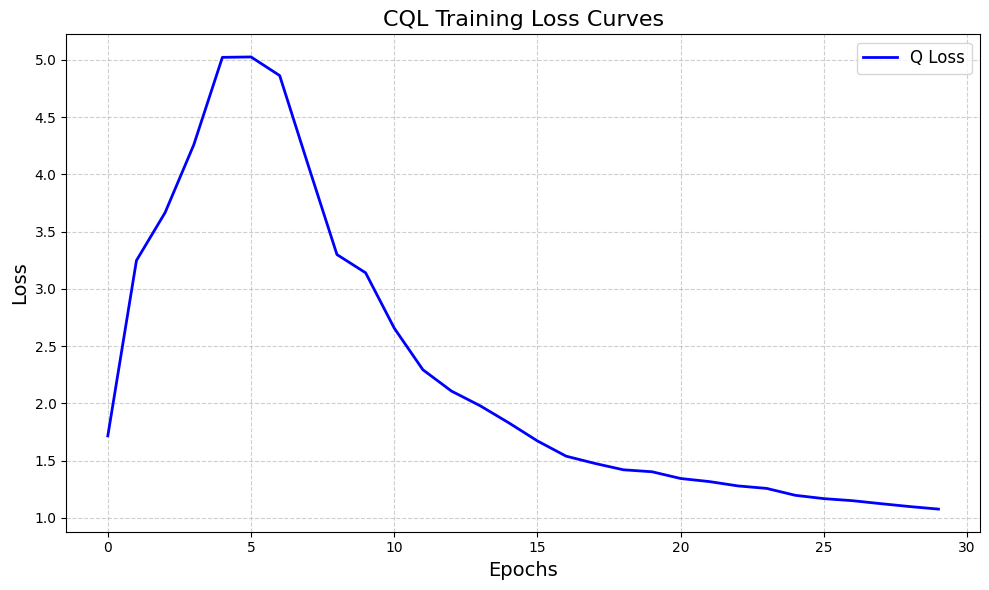

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(plot_length, total_q_loss, label='Q Loss', color='blue', linewidth=2)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('CQL Training Loss Curves', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('CQL_loss_curves.png', dpi=300)  # Save as PNG
plt.show()
